In [290]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
from pymongo import MongoClient
from data import Database
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


In [299]:
def load_data():
    db = Database(collection_name='monsters')
    return db.dataframe()


In [300]:
df = load_data()
df.head()

,_id,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,66dd9aa85cd9ba0cf6e97f57,Skeletal Guard,Undead,11,Rank 0,11d2+1,21.48,21.25,21.07,2024-09-08 05:38:00
1,66dd9aa85cd9ba0cf6e97f58,Djinni,Elemental,8,Rank 2,8d6+3,48.11,46.48,50.14,2024-09-08 05:38:00
2,66dd9aa85cd9ba0cf6e97f59,Lightning Devil,Devilkin,10,Rank 3,10d8+3,83.40,78.21,78.46,2024-09-08 05:38:00
3,66dd9aa85cd9ba0cf6e97f5a,Night Hag,Demonic,3,Rank 0,3d2+2,5.33,6.59,5.75,2024-09-08 05:38:00
4,66dd9aa85cd9ba0cf6e97f5b,Onyx Dragon,Dragon,2,Rank 1,2d4,7.09,8.86,7.81,2024-09-08 05:38:00


In [301]:
print(df.isna().sum())

_id          0
Name         0
Type         0
Level        0
Rarity       0
Damage       0
Health       0
Energy       0
Sanity       0
Timestamp    0
dtype: int64


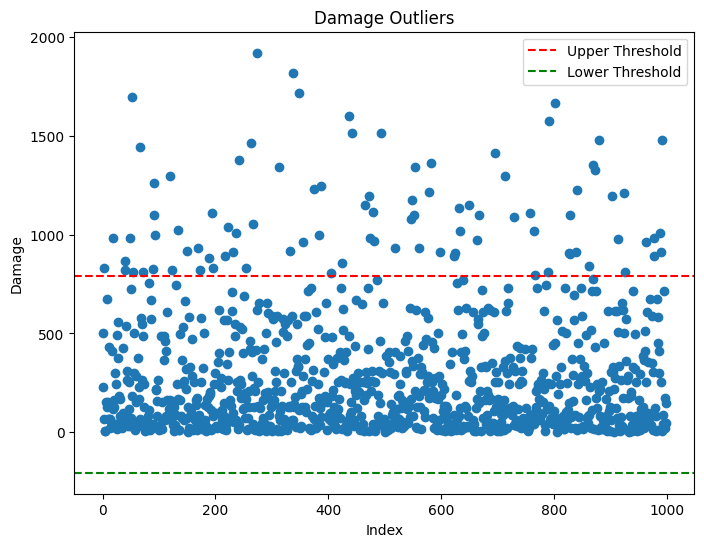

In [302]:
#  Convert Damage column to numeric values (remove 'd' and '+')
def convert_damage(x):
    if isinstance(x, str):
        return eval(x.replace('d', '*').replace('+', ''))
    else:
        return x

df['Damage'] = df['Damage'].apply(convert_damage)
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(df)), df['Damage'])
plt.axhline(y=df['Damage'].mean() + 1.5 * df['Damage'].std(), color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=df['Damage'].mean() - 1.5 * df['Damage'].std(), color='green', linestyle='--', label='Lower Threshold')
plt.title('Damage Outliers')
plt.xlabel('Index')
plt.ylabel('Damage')
plt.legend()
plt.show()

In [324]:
y = df["Rarity"]
X = df.drop(columns=["Rarity", "_id", "Name", "Timestamp", "Damage", "Type"])


In [325]:
df['Rarity'].unique()

array(['Rank 0', 'Rank 2', 'Rank 3', 'Rank 1', 'Rank 4', 'Rank 5'],
      dtype=object)

In [326]:
import pandas as pd

# Convert y to Pandas Series
y_series = pd.Series(y)

# Define mapping
rarity_map = {
    'Rank 0': 0,
    'Rank 1': 1,
    'Rank 2': 2,
    'Rank 3': 3,
    'Rank 4': 4,
    'Rank 5': 5,
}

# Convert Rarity to numerical values
y = y_series.map(rarity_map).values


In [327]:
y

array([0, 2, 3, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1,
       0, 0, 1, 1, 0, 2, 1, 2, 0, 1, 1, 4, 0, 3, 4, 2, 2, 2, 5, 1, 2, 0,
       0, 0, 0, 3, 5, 0, 5, 3, 5, 2, 3, 0, 3, 1, 0, 0, 0, 2, 0, 1, 1, 0,
       4, 2, 2, 2, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 2, 1, 2, 2, 0, 2, 3, 0,
       0, 4, 1, 3, 5, 3, 1, 1, 4, 1, 0, 1, 2, 0, 2, 3, 2, 0, 0, 1, 2, 3,
       1, 5, 3, 3, 2, 3, 0, 4, 4, 3, 3, 0, 2, 3, 5, 0, 2, 0, 3, 1, 3, 4,
       3, 2, 1, 1, 0, 1, 2, 0, 2, 0, 1, 3, 2, 1, 3, 0, 2, 4, 3, 0, 0, 0,
       2, 1, 1, 2, 0, 1, 1, 2, 0, 3, 2, 1, 0, 1, 0, 0, 2, 1, 1, 2, 2, 0,
       0, 1, 3, 1, 2, 3, 4, 4, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 5, 1, 3, 3,
       3, 0, 1, 3, 2, 2, 0, 1, 2, 0, 5, 0, 0, 2, 0, 0, 3, 0, 3, 3, 2, 1,
       2, 1, 2, 0, 4, 0, 1, 4, 0, 1, 4, 0, 3, 2, 2, 2, 0, 2, 2, 0, 2, 3,
       2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 4, 4, 1, 0, 0, 4, 3, 1, 1, 1, 5,
       3, 0, 2, 3, 0, 1, 0, 1, 3, 2, 4, 0, 1, 3, 0, 2, 3, 0, 3, 2, 4, 3,
       1, 0, 0, 1, 0, 3, 2, 1, 1, 3, 0, 1, 1, 1, 1,

In [328]:
# Define preprocessor for categorical and numerical columns
# categorical_cols = ['Type']  # Example categorical columns
numerical_cols = ['Level', 'Health', 'Energy', 'Sanity']  # Example numerical columns

In [329]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        # ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), categorical_cols)
    ]
)

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
# Baseline 
# Get the unique classes and their counts
classes, counts = np.unique(y, return_counts=True)

# Print the class distribution
for class_, count in zip(classes, counts):
    print(f"Class {class_}: {count} ({count/len(y)*100:.2f}%)")

Class 0: 295 (29.50%)
Class 1: 261 (26.10%)
Class 2: 198 (19.80%)
Class 3: 138 (13.80%)
Class 4: 75 (7.50%)
Class 5: 33 (3.30%)


In [374]:
# Logistic regression
model_lr = make_pipeline(
    preprocessor,
    LogisticRegression()
)

In [375]:
# Decision Tree
model_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier()
)

In [376]:
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier()
)

In [377]:
model_lr.fit(X,y)
model_dt.fit(X,y)
model_rf.fit(X,y)

c:\Users\ISHMO_CT\.virtualenvs\BandersnatchStarter-idHz4lOD\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Level', 'Health', 'Energy',
                                                   'Sanity'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [378]:
# trainning_accuarancy for the three models
model_lr_acc = model_lr.score(X_train,y_train)
model_dt_acc = model_dt.score(X_train, y_train)
model_rf_acc = model_rf.score(X_train,y_train)
print("Training accurancy Logistic Regression", model_lr_acc )
print("Training accurancy Decission Tree", model_dt_acc )
print("Training accurancy Random Forest", model_rf_acc )

Training accurancy Logistic Regression 0.985
Training accurancy Decission Tree 1.0
Training accurancy Random Forest 1.0


In [379]:
param_grid_rf = {
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4], 
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

param_grid_dt = {
    'decisiontreeclassifier__max_depth': [5, 10, 20, None],
    'decisiontreeclassifier__min_samples_split': [2, 8, 20, 50],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
}


In [380]:
model_rf_gs = GridSearchCV(model_rf, param_grid=param_grid_rf, n_jobs=-1, cv=5, verbose=1)
model_dt_gs = GridSearchCV(model_dt, param_grid=param_grid_dt, n_jobs=-1, cv=5, verbose=1)


In [381]:
model_rf_gs.fit(X_train, y_train)
model_dt_gs.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['Level',
                                                                          'Health',
                                                                          'Energy',
                                                                          'Sanity'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [5, 10, 20, None],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
                         'decisiontreeclassifier__min_samples_split': [2, 8, 20,
                                                                       50]},
             verbose=1)

In [354]:
# findout the best parameter 
print("best parameter_rainforest", model_rf_gs.best_params_)
print("best parameter_decision tree", model_dt_gs.best_params_)

best parameter_rainforest {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
best parameter_decision tree {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}


In [355]:
model_rf_best_parameters = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=20, n_estimators=100, criterion='gini', min_samples_leaf=1, min_samples_split=2)
)
model_dt_best_parameters = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=10, min_samples_split=2, criterion='entropy', min_samples_leaf=1)
)

In [356]:
model_rf_best_parameters.fit(X_train, y_train)
model_dt_best_parameters.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Level', 'Health', 'Energy',
                                                   'Sanity'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10))])

In [357]:
print(model_rf_best_parameters.score(X_train, y_train))
print(model_dt_best_parameters.score(X_train, y_train))


1.0
0.9985714285714286


In [365]:
X_test

,Level,Health,Energy,Sanity
0,11,21.48,21.25,21.07
1,8,48.11,46.48,50.14
2,10,83.40,78.21,78.46
3,3,5.33,6.59,5.75
4,2,7.09,8.86,7.81
...,...,...,...,...
995,17,69.02,69.12,67.25
996,8,15.83,16.35,15.12
997,4,21.32,26.38,25.27
998,1,2.71,4.48,5.77


In [368]:
print(model_rf_best_parameters.score(X_test, y_test))
print(model_dt_best_parameters.score(X_test, y_test))

0.9466666666666667
0.93


In [369]:
print(model_lr.score(X_test, y_test))

0.99


|  Test Data          |                | Training Data       |                |
|---------------------|----------------|---------------------|----------------|
| Model               | Accuracy Score | Model               | Accuracy Score |
|---------------------|----------------|---------------------|----------------|
| Logistic Regression | 0.99           | Logistic Regression | 0.9857         |
| Random Forest       | 0.9467         | Random Forest       | 1.0            |
| Decision Tree       | 0.93           | Decision Tree       | 0.9986         |



### Based on the accuracy scores and observations:
Best Model: Logistic Regression
### Reasons:
Highest test accuracy:
Logistic Regression achieved the highest accuracy score on test data (0.99).
- Best generalization: 
Logistic Regression showed the smallest gap between training and test accuracy scores, indicating better generalization.
- Simple and efficient: 
Logistic Regression is a simple and computationally efficient model, making it suitable for deployment.

While Random Forest and Decision Tree models performed well on training data, their test accuracy scores were lower, indicating overfitting. Logistic Regression's balance of accuracy and generalization makes it the top choice.